# 4.Amazon_Kinesis_Data_Analytics_RCF

This notebook shows how to compute an anomaly score using [RANDOM_CUT_FOREST_WITH_EXPLANATION](https://docs.aws.amazon.com/kinesisanalytics/latest/sqlref/sqlrf-random-cut-forest-with-explanation.html) in Amazon Kinesis Data Analytics for each record in clickstreams. After creating Kinesis Data streams for source and destination, Amazon Kinesis Data Analytics detects anomalies in the input data stream. A record is an anomaly if it is distant from other records.The algorithm starts developing the machine learning model using current records in the stream when you start the application. The algorithm does not use older records in the stream for machine learning, nor does it use statistics from previous executions of the application.

## Table Of Contents
The overall process for this is:

* 1) Setup
* 2) Creating data streams
* 3) Creating IAM Role
* 4) Creating the Kinesis Data Analytics Application
* 5) Starting the Kinesis Data Analytics Application
* 6) Data Preparation
* 7) Sending Input streams
* 8) Plotting the Prediction
* 9) Stopping and Deleting the Kinesis Data Analytics Application

To get started, simply execute the cells below:

## 1) Setup

AWS Data Wrangler is installed and Anomaly results from Amazon Kinesis are put to Amazon S3 easily through AWS Data Wrangler during performing Amazon Kinesis Data Analytics.

In [1]:
import sys

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install awswrangler

  Using cached pip-20.2.2-py2.py3-none-any.whl (1.5 MB)
  Attempting uninstall: pip
    Found existing installation: pip 20.1.1
    Uninstalling pip-20.1.1:
      Successfully uninstalled pip-20.1.1
     |████████████████████████████████| 125 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 9.6 MB/s  eta 0:00:01
     |████████████████████████████████| 2.9 MB 65.4 MB/s eta 0:00:01


In [6]:
import json
import random
import boto3
import os
import time
import numpy as np
import pandas as pd
import awswrangler as wr

import matplotlib.pyplot as plt

%matplotlib inline 

In [7]:
kinesis_client = boto3.client('kinesis')
kinesis_analytics = boto3.client('kinesisanalytics')

In [8]:
sess = boto3.Session()

# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client('sts').get_caller_identity()["Account"]
job_bucket = 's3://sagemaker-experiments-{}-{}'.format(sess.region_name, account_id)
job_bucket

's3://sagemaker-experiments-us-east-2-322537213286'

In [29]:
%store -r

## 2) Creating data streams

We first create a Kinesis data stream, which serves as a short term streaming store for clickstreams. The throughput of an Amazon Kinesis data stream is determined by the number of shards within the data stream. We can calculate the initial number of shards (number_of_shards) the data stream needs using the following formula:

number_of_shards = max (incoming_write_bandwidth_in_KB/1000, outgoing_read_bandwidth_in_KB/2000)

In [9]:
data_stream = ['clickstream_input', 'clickstream_output']

try:
    for stream in data_stream:
        kinesis_client.create_stream(
            StreamName=stream,
            ShardCount=1
        )
except Exception as e:
    if e.response['Error']['Code'] == 'ResourceInUseException':
        print(e.response['message'])
    else:
        print(e.response['Error']['Code'])
    

Stream clickstream_input under account 322537213286 already exists.


In [10]:
# Wait until all streams are created
result = {}
waiter = kinesis_client.get_waiter('stream_exists')
for stream in data_stream:
    waiter.wait(StreamName=stream)
    response = kinesis_client.describe_stream(StreamName=stream)
    result[stream] = response["StreamDescription"]["StreamARN"]

## 3) Creating IAM Role

In this step, we are going to create an IAM role and add an policy that we will use in the Kinesis to read for inputstream and write for outputstream.

In [11]:
region = boto3.Session().region_name

iam = boto3.client('iam')
sts = boto3.client('sts')

In [12]:
kinesis_role_name = 'kinesis-analytics-{}'.format(region)
kinesis_analytics_policy_name=kinesis_role_name + '_policy'
kinesis_role_name

'kinesis-analytics-us-east-2'

In [13]:
kinesis_assume_role={
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Principal": {
        "Service": "kinesisanalytics.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    }
  ]
}

In [14]:
kinesis_analytics_policy = {
  "Version": "2012-10-17",
  "Statement": [
    {
      "Sid": "ReadInputKinesis",
      "Effect": "Allow",
      "Action": [
        "kinesis:DescribeStream",
        "kinesis:GetShardIterator",
        "kinesis:GetRecords"
      ],
      "Resource": [
        result['clickstream_input']
      ]
    },
    {
      "Sid": "WriteOutputKinesis",
      "Effect": "Allow",
      "Action": [
        "kinesis:DescribeStream",
        "kinesis:PutRecord",
        "kinesis:PutRecords"
      ],
      "Resource": [
        result['clickstream_output']
      ]
    }
  ]
}

In [15]:
try:
    role_res = iam.create_role(
        Path='/service-role/',
        RoleName=kinesis_role_name,
        AssumeRolePolicyDocument=json.dumps(kinesis_assume_role),
    )
except Exception as e:
    if e.response['Error']['Code'] == 'EntityAlreadyExists':
        role_res = iam.get_role(
            RoleName=kinesis_role_name
        )
        print("User already exists")
    else:
        print("Unexpected error: %s" % e)

User already exists


In [16]:
try:
    policy_res = iam.create_policy(
        PolicyName=kinesis_analytics_policy_name,
        Path='/',
        PolicyDocument=json.dumps(kinesis_analytics_policy)
    )
except Exception as e:
    if e.response['Error']['Code'] == 'EntityAlreadyExists':
        PolicyArn ='arn:aws:iam::{}:policy/{}'.format(account_id, kinesis_analytics_policy_name)
        policy_res = iam.get_policy(
            PolicyArn=PolicyArn
        )
        print("User already exists")
    else:
        print("Unexpected error: %s" % e)

User already exists


In [17]:
from botocore.exceptions import ClientError

try:
    attach_res = iam.attach_role_policy(
        PolicyArn=policy_res['Policy']['Arn'],
        RoleName=kinesis_role_name
    )
    print("Policy has been succesfully attached to role: %s" % kinesis_role_name)
except Exception as e:
    print("Unexpected error: %s" % e)

Policy has been succesfully attached to role: kinesis-analytics-us-east-2


## 4) Creating the Kinesis Data Analytics Application


We configure the application input to use the Kinesis data stream we created as the streaming source. we can add the SQL and destination stream in Kinesis Analytics as the below.The parameters of the RANDOM_CUT_FOREST_WITH_EXPLANATION function is defined as numberOfTrees, subSampleSize, timeDecay, shingleSize, and withDirectionality.

* **numberOfTrees** : the number of random cut trees in the forest. 
* **subSampleSize** : the size of the random sample that you want the algorithm to use when constructing each tree
* **timeDecay** : how much of the recent past to consider when computing an anomaly score
* **shingleSize** : the size of the consecutive sequence of the most recent records. For example, a shingleSize of 10 at time t corresponds to a vector of the last 10 records received up to and including time t. The algorithm treats this sequence as a vector over the last shingleSize number of records. If you set the shingleSize too small, the algorithm is more susceptible to minor fluctuations in the data, leading to high anomaly scores for records that are not anomalous.
If you set the shingleSize too large, it might take more time to detect anomalous records because there are more records in the shingle that are not anomalous. It also might take more time to determine that the anomaly has ended.
* **withDirectionality** : When set to true, it tells you the direction in which each individual dimension makes a contribution to the anomaly score. It also provides the strength of the recommendation for that directionality.

In [18]:
%%writefile random_cut_forest_with_explanation.sql

-- ** Anomaly detection **
-- Compute an anomaly score for each record in the source stream using Random Cut Forest
-- Creates a temporary stream and defines a schema
                                
CREATE OR REPLACE STREAM "TEMP_STREAM" (
   "TIMESTAMPS"          TIMESTAMP,
   "URLS"                INTEGER,
   "USERS"               INTEGER,
   "CLICKS"              INTEGER,
   "ANOMALY_SCORE"       DOUBLE,
   "ANOMALY_EXPLANATION" varchar(512));
-- Creates an output stream and defines a schema
CREATE OR REPLACE STREAM "DESTINATION_SQL_STREAM" (
   "TIMESTAMPS"          TIMESTAMP,
   "URLS"                INTEGER,
   "USERS"               INTEGER,
   "CLICKS"              INTEGER,
   "ANOMALY_SCORE"       DOUBLE,
   "ANOMALY_EXPLANATION" varchar(512));


-- RANDOM_CUT_FOREST anomaly score is a number between 0 and LOG2(subSampleSize)
-- See RANDOM_CUT_FOREST anomaly score explanation https://forums.aws.amazon.com/message.jspa?messageID=751928
-- Normalize the "ANOMALY_SCORE" by dividing it by LOG2(subSampleSize)
--   "shingleSize": 4, 24, 48
--    "numberOfTrees" : 100, 200

CREATE OR REPLACE PUMP "STREAM_PUMP" AS INSERT INTO "TEMP_STREAM"
SELECT STREAM "TIMESTAMPS", "URLS", "USERS", "CLICKS", "ANOMALY_SCORE", "ANOMALY_EXPLANATION" FROM
  TABLE(RANDOM_CUT_FOREST_WITH_EXPLANATION(
    CURSOR(SELECT STREAM * FROM "SOURCE_SQL_STREAM_001"), -- inputStream
    100, -- numberOfTrees
    256, -- subSampleSize
    100000, -- timeDecay
    1, -- shingleSize
    true
  )
);

CREATE OR REPLACE PUMP "OUTPUT_PUMP" AS INSERT INTO "DESTINATION_SQL_STREAM"
SELECT STREAM * FROM "TEMP_STREAM"
ORDER BY FLOOR("TEMP_STREAM".ROWTIME TO SECOND), ANOMALY_SCORE DESC;

Overwriting random_cut_forest_with_explanation.sql


In [19]:
sql_query = open('random_cut_forest_with_explanation.sql', "r").read()

In [20]:
kinesis_ApplicationName='clickstream-analytics-rcf-explanation-{}'.format(int(time.time()))

In [21]:
try:
    response = kinesis_analytics.create_application(
        ApplicationName=kinesis_ApplicationName,
        ApplicationCode=sql_query,
        Inputs=[
            {
                'NamePrefix': 'SOURCE_SQL_STREAM',
                'KinesisStreamsInput': {
                    'ResourceARN': result[data_stream[0]],
                    'RoleARN': role_res['Role']['Arn']
                },
                'InputSchema': {
                    'RecordFormat': {
                        'RecordFormatType': 'JSON',
                        'MappingParameters': {
                            'JSONMappingParameters': {
                                'RecordRowPath': '$'
                            },
                        }
                    },
                    'RecordEncoding': 'UTF-8',
                    'RecordColumns': [
                                {
                                    "SqlType": "TIMESTAMP",
                                    "Name": "TIMESTAMPS",
                                    "Mapping": "$.timestamp"
                                },
                                {
                                    "SqlType": "INTEGER",
                                    "Name": "URLS",
                                    "Mapping": "$.urls"
                                },
                                {
                                    "SqlType": "INTEGER",
                                    "Name": "USERS",
                                    "Mapping": "$.users"
                                },
                                {
                                    "SqlType": "INTEGER",
                                    "Name": "CLICKS",
                                    "Mapping": "$.clicks"
                                }
                    ],
                    "RecordFormat": {
                        "MappingParameters": {
                            'JSONMappingParameters': {
                                'RecordRowPath': '$'
                            },
                        },
                        "RecordFormatType": "JSON"
                      }
                }
            },
        ],
        Outputs=[
            {
                'Name': 'DESTINATION_SQL_STREAM',
                'DestinationSchema': {
                    'RecordFormatType': 'JSON'
                },
                "KinesisStreamsOutput": {
                    "ResourceARN": result[data_stream[1]],
                    "RoleARN": role_res['Role']['Arn']
                }
            },
        ],
    )
except Exception as e:
    if e.response['Error']['Code'] == 'ResourceInUseException':
        print(e.response['message'])
    else:
        print(e)

## 5) Starting the Kinesis Data Analytics Application

We start the Amazon Kinesis Analytics application. After the application starts, it begins consuming the input data, processes it, and writes the output to the configured destination.

In [22]:
response = kinesis_analytics.describe_application(
    ApplicationName=kinesis_ApplicationName
)

application = response["ApplicationDetail"]
inputId = application['InputDescriptions'][0]['InputId']

try:
    kinesis_analytics.start_application(ApplicationName=kinesis_ApplicationName,
                                     InputConfigurations=[{
                                       "Id": inputId,
                                       "InputStartingPositionConfiguration": {
                                         "InputStartingPosition": "NOW"
                                       }
                                     }])
except Exception as e:
    if e.response['Error']['Code'] == 'ResourceInUseException':
        print(e.response['message'])
    else:
        print(e.response['Error']['Code'])

In [23]:
# Wait until application starts running
response = kinesis_analytics.describe_application(
    ApplicationName=kinesis_ApplicationName
)
status = response["ApplicationDetail"]["ApplicationStatus"]

sys.stdout.write('Starting ')
while status != "RUNNING":
    sys.stdout.write('.')
    sys.stdout.flush()
    time.sleep(1)
    response = kinesis_analytics.describe_application(
      ApplicationName=kinesis_ApplicationName
    )
    status = response["ApplicationDetail"]["ApplicationStatus"]
sys.stdout.write('RUNNING')
sys.stdout.write(os.linesep)

Starting ....................................................................................RUNNING


##  6) Data Preparation
For preparing a training dataset, We use aggagated timeseries with 3 features of the number of visited urls, the number of visitors, and the numbor of clicks in 1 minute.

In [30]:
resampling_clickstream = filtered_clickstream.set_index('timestamp').resample('1T')
training_data = resampling_clickstream.nunique()[['url','user_session_id']]
training_data['clicks'] = resampling_clickstream.count()['clickstream_id']
training_data.columns = ['urls','users','clicks']
training_data.head()

,urls,users,clicks
timestamp,,,
2012-03-01 00:00:00,3,4,5
2012-03-01 00:01:00,2,3,4
2012-03-01 00:02:00,1,4,4
2012-03-01 00:03:00,4,4,5
2012-03-01 00:04:00,5,6,9


we look at time series trends and patterns graphically as plotting the training data.

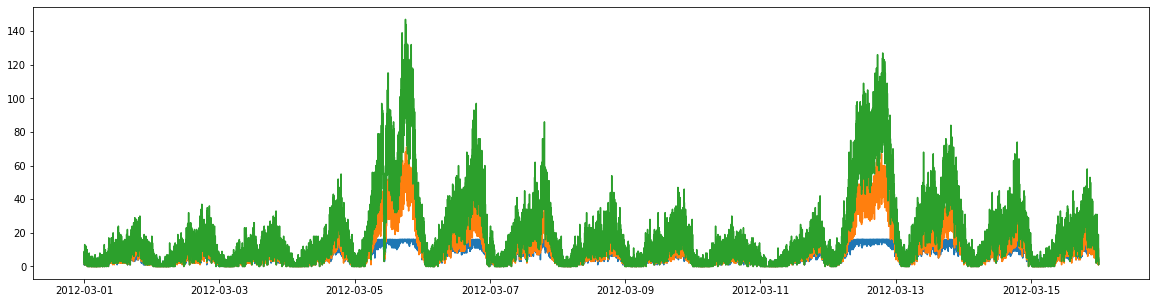

In [31]:
plt.figure(figsize=(20,5))
plt.plot(training_data)
plt.show()

In [32]:
training_data = training_data.reset_index()
col_names = training_data.keys().to_list()
col_names

['timestamp', 'urls', 'users', 'clicks']

## 7) Sending Input streams

Function make_kinesis_data converts realtime data to a input type of kinesis analytics put_record.

In [33]:
def make_kinesis_data(df, i, col_names):
    kinesis_data = {}
    kinesis_data['timestamp']=str(df['timestamp'][i])
    for col_name in col_names:
        if col_name not in ['timestamp']:
            kinesis_data[col_name]=int(df.iloc[i][col_name])
    return kinesis_data

Function s3_sink makes results of the Kinesis analytics to put Amazon S3. We can verify the output of the application in the Amazon S3.

In [34]:
def s3_sink(shardIterator):
    rows = []
    response = kinesis_client.get_records(ShardIterator=shardIterator)
    records = response["Records"]

    try:
        while len(records) > 0:
            parsed_records = []
            for rec in records:
                parsed_record = json.loads(rec["Data"])
                parsed_records.append(parsed_record)
            rows.extend(parsed_records)
            time.sleep(1)
            shardIterator = response["NextShardIterator"]
            response = kinesis_client.get_records(ShardIterator=shardIterator)
            records = response["Records"]
        flag = rows[0]['TIMESTAMPS'].replace(":","-").replace(" ","-").replace(".","-")
        s3_save_path = '{}/{}/{}'.format(job_bucket, 'kinesis-analytics', flag)
        wr.s3.to_csv(
            df=pd.DataFrame(rows),
            path=s3_save_path
        )
    except:
        sys.stdout.write("[ExpiredIteratorException] Iterator expired.")
        pass
    return rows

Similar to streaming data in real-time, we put clickstreams into Kinesis Data Analytics through Kinesis Data Stream by one record using For statement. Anomaly score and explanation add to clickstreams through Kinesis analytics.

In [35]:
response = kinesis_client.describe_stream(StreamName=data_stream[1])
shardId = response["StreamDescription"]["Shards"][0]["ShardId"]
shard_response = kinesis_client.get_shard_iterator(StreamName=data_stream[1],
                                    ShardId=shardId,
                                    ShardIteratorType="LATEST")
shardIterator = shard_response["ShardIterator"]

result = []
rnd=random.random()

for idx in training_data.index:
    kinesis_data = json.dumps(make_kinesis_data(training_data, idx, col_names))
    kinesis_client.put_record(
        StreamName=data_stream[0],
        Data=kinesis_data,
        PartitionKey=str(rnd)
    )
time.sleep(3)
result.extend(s3_sink(shardIterator))

In [36]:
len(result)

21600

In [37]:
from datetime import datetime

revised_result = []
for row in result:
    result_row = {}
    result_row['TIMESTAMPS'] = datetime.strptime(row['TIMESTAMPS'].split('.')[0],'%Y-%m-%d %H:%M:%S')
    result_row['URLS'] = row['URLS']
    result_row['USERS'] = row['USERS']
    result_row['CLICKS'] = row['CLICKS']
    result_row['ANOMALY_SCORE'] = row['ANOMALY_SCORE']
    
    anomaly_exp = json.loads(row['ANOMALY_EXPLANATION'])
    result_row['URLS_STRENGTH'] = float(anomaly_exp['URLS']['STRENGTH'])
    result_row['URLS_ATTRIBUTION_SCORE'] = float(anomaly_exp['URLS']['STRENGTH'])
    result_row['USERS_STRENGTH'] = float(anomaly_exp['USERS']['STRENGTH'])
    result_row['USERS_ATTRIBUTION_SCORE'] = float(anomaly_exp['USERS']['ATTRIBUTION_SCORE'])
    result_row['CLICKS_STRENGTH'] = float(anomaly_exp['CLICKS']['STRENGTH'])
    result_row['CLICKS_ATTRIBUTION_SCORE'] = float(anomaly_exp['CLICKS']['ATTRIBUTION_SCORE'])
    revised_result.append(result_row)

In [38]:
training_data = training_data.set_index('timestamp')

The explanation provides the following values for each column in the record:

* **Attribution score** : A nonnegative number that indicates how much this column has contributed to the anomaly score of the record
* **Strength** : A nonnegative number representing the strength of the directional recommendation. 
* **Directionality** : This is either HIGH if the value of the column is above the recently observed trend or LOW if it’s below the trend. During the learning phase, this defaults to LOW.


In [39]:
result_data = pd.DataFrame(revised_result)
result_data = result_data.sort_values(by=['TIMESTAMPS'])
result_data = result_data.set_index('TIMESTAMPS')
result_data.head(5)

,URLS,USERS,CLICKS,ANOMALY_SCORE,URLS_STRENGTH,URLS_ATTRIBUTION_SCORE,USERS_STRENGTH,USERS_ATTRIBUTION_SCORE,CLICKS_STRENGTH,CLICKS_ATTRIBUTION_SCORE
TIMESTAMPS,,,,,,,,,,
2012-03-01 00:00:00,3,4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-03-01 00:01:00,2,3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-03-01 00:02:00,1,4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-03-01 00:03:00,4,4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-03-01 00:04:00,5,6,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's look at the distribution of our anomaly score.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc60638e6d8>]],
      dtype=object)

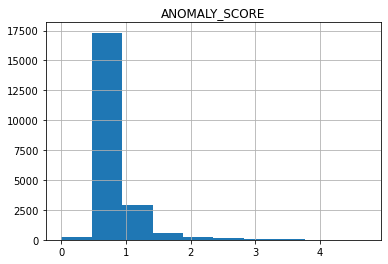

In [40]:
results_pd = pd.DataFrame(result_data['ANOMALY_SCORE'])
results_pd.hist()

## 8) Plotting the Prediction

We can find the algorthim is detecting anomalies with the change and deviation of each feature value instead of using a fixed threshold.

In [41]:
threshold = 1.4

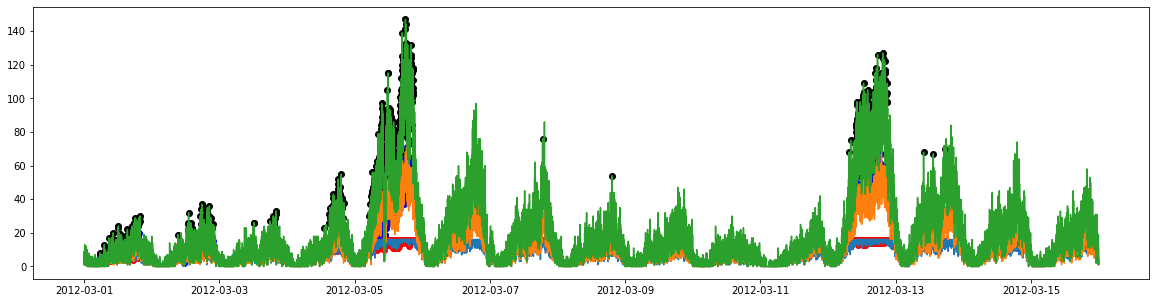

In [42]:
plt.figure(figsize=(20,5))
plt.plot(result_data[['URLS','USERS','CLICKS']])

anomalous = result_data[list((results_pd > threshold)['ANOMALY_SCORE'])]
plt.scatter(x= anomalous.index, y=anomalous['URLS'].values, c='red')
plt.scatter(x= anomalous.index, y=anomalous['USERS'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['CLICKS'].values, c='black')
plt.show()

We enlarge the time period in detail from March 13, 2012 8:00 to March 13, 2012 23:00 to look at the detecting abnormal spike.

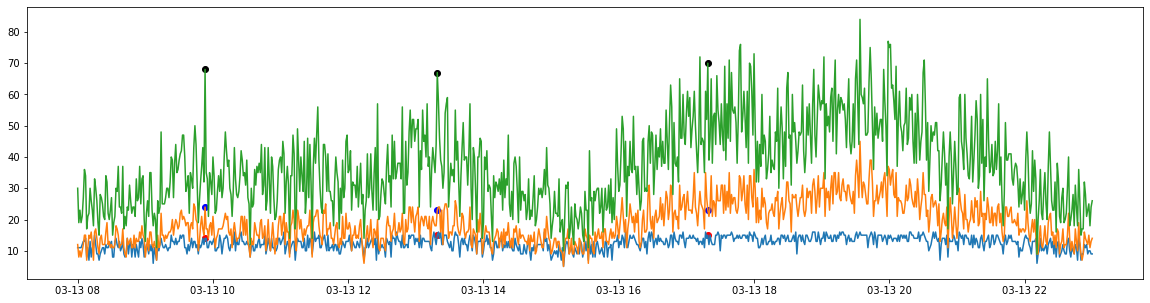

In [43]:
plt.figure(figsize=(20,5))
plt.plot(result_data[['URLS','USERS','CLICKS']]["2012-03-13 08:00:00":"2012-03-13 23:00:00"])

anomalous = result_data[list((results_pd > threshold)['ANOMALY_SCORE'])]["2012-03-13 08:00:00":"2012-03-13 23:00:00"]
plt.scatter(x= anomalous.index, y=anomalous['URLS'].values, c='red')
plt.scatter(x= anomalous.index, y=anomalous['USERS'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['CLICKS'].values, c='black')
plt.show()

We normalize the anomaly score and explanation information so that they can be viewed in a single plot. Through this, we check which values most affected the anomaly score.

In [44]:
from sklearn.preprocessing import MinMaxScaler
import copy

normalized_result_data = copy.deepcopy(result_data)
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(normalized_result_data) 
normalized_result_data.loc[:,:] = scaled_values

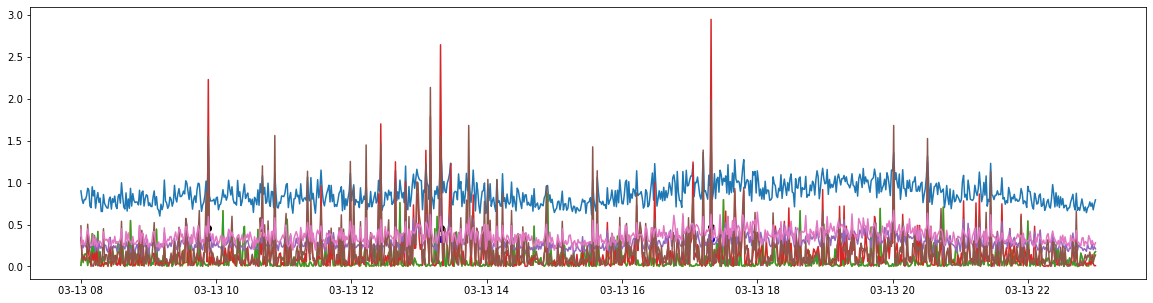

In [45]:
plt.figure(figsize=(20,5))
plt.plot(result_data[['ANOMALY_SCORE','URLS_STRENGTH','URLS_ATTRIBUTION_SCORE','USERS_STRENGTH','USERS_ATTRIBUTION_SCORE','CLICKS_STRENGTH','CLICKS_ATTRIBUTION_SCORE']]["2012-03-13 08:00:00":"2012-03-13 23:00:00"])

anomalous = normalized_result_data[list((results_pd > threshold)['ANOMALY_SCORE'])]["2012-03-13 08:00:00":"2012-03-13 23:00:00"]
plt.scatter(x= anomalous.index, y=anomalous['USERS'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['CLICKS'].values, c='black')
plt.show()

In [38]:
high_anomaly=result_data["2012-03-13 08:00:00":"2012-03-13 23:00:00"]
high_anomaly.sort_values(by=['ANOMALY_SCORE'], ascending=False).head(5)

,URLS,USERS,CLICKS,ANOMALY_SCORE,URLS_STRENGTH,URLS_ATTRIBUTION_SCORE,USERS_STRENGTH,USERS_ATTRIBUTION_SCORE,CLICKS_STRENGTH,CLICKS_ATTRIBUTION_SCORE
TIMESTAMPS,,,,,,,,,,
2012-03-13 17:19:00,15,23,70,1.501229,0.0000,0.0000,2.9491,0.8520,1.9846,0.6222
2012-03-13 09:53:00,14,24,68,1.453114,0.0023,0.0023,2.2307,0.7973,1.5472,0.5938
2012-03-13 13:19:00,15,23,67,1.437916,0.0003,0.0003,2.6460,0.8097,1.5575,0.5976
2012-03-13 17:12:00,13,29,72,1.359988,0.0573,0.0573,0.9466,0.5399,1.3888,0.5955
2012-03-13 20:01:00,15,31,76,1.357581,0.0007,0.0007,1.2297,0.6382,1.6823,0.6708


## 9) Stopping and Deleting the Kinesis Data Analytics Application

In [39]:
kinesis_analytics.stop_application(ApplicationName=kinesis_ApplicationName)

# Wait until application stops running
response = kinesis_analytics.describe_application(
    ApplicationName=kinesis_ApplicationName
)
status = response["ApplicationDetail"]["ApplicationStatus"]
sys.stdout.write('Stopping ')

while status != "READY":
    sys.stdout.write('.')
    sys.stdout.flush()
    time.sleep(1)
    response = kinesis_analytics.describe_application(
        ApplicationName=kinesis_ApplicationName
    )
    status = response["ApplicationDetail"]["ApplicationStatus"]

sys.stdout.write(os.linesep)

Stopping ....


In [40]:
kinesis_analytics.delete_application(ApplicationName=kinesis_ApplicationName,
                                     CreateTimestamp=response['ApplicationDetail']['CreateTimestamp'])

{'ResponseMetadata': {'RequestId': 'c9ccb1c3-2108-4773-b989-7c308f6c57fa',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c9ccb1c3-2108-4773-b989-7c308f6c57fa',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'date': 'Sat, 22 Aug 2020 00:41:25 GMT'},
  'RetryAttempts': 0}}